In [1]:
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle


In [17]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if color_space == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if color_space == 'LUV':
        return  cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if color_space == 'HLS':
        return  cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if color_space == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if color_space == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



In [3]:
def extract_single_image_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    file_features = []
    
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    if hist_feat == True:
        # Apply color_hist()
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    if hog_feat == True:
    # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
        
    return file_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        #print('image shape ', image.shape)
        
        file_features = extract_single_image_features(image, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, hog_channel,
                        spatial_feat, hist_feat, hog_feat)

        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [4]:
import glob
image_filenames = glob.glob('test_images/test*.jpg')
#plt.imshow(image)

features = extract_features(image_filenames, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

print('features.shape ', len(features))
print('features[0].shape ', features[0].shape)

/Users/tavant/miniconda3/envs/carnd-term1-cpu/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


features.shape  6
features[0].shape  (512604,)


In [46]:
# Tune the parameters here

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


# find_cars parameters
ystart = 400
ystop = 680
scale = 1.5


In [35]:
from sklearn.cross_validation import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

def train(cars, notcars):
    print('no. of not car images is ', len(notcars))
    print('no. of car images is ', len(cars))

    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]

    car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)

    print('X_train shape', X_train.shape)
    print('X_test shape', X_test.shape)

    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_train = X_scaler.transform(X_train)
    X_test = X_scaler.transform(X_test)

    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    accuracy_score = round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', accuracy_score)
    # Check the prediction time for a single sample
    t=time.time()

    return svc, X_scaler, accuracy_score


notcars = glob.glob('../CarND-Vehicle-Detection-Data/non-vehicles/**/*.png')
cars = glob.glob('../CarND-Vehicle-Detection-Data/vehicles/**/*.png')

svc, X_scaler, accuracy_score = train(cars, notcars)

no. of not car images is  8968
no. of car images is  8792


/Users/tavant/miniconda3/envs/carnd-term1-cpu/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


X_train shape (800, 6108)
X_test shape (200, 6108)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
0.16 Seconds to train SVC...
Test Accuracy of SVC =  0.99


In [60]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    print('spatial_size ', spatial_size)
    print('hist ', hist_bins)
    print('orient ', orient)
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        #print('imshape ', imshape)
        #print('ctrans_tosearch ', ctrans_tosearch)
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]


    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
        
    print('ch1.shape[1] ', ch1.shape[1])
    print('pix_per_cell ', pix_per_cell)
    print('(ch1.shape[1] // pix_per_cell) ', (ch1.shape[1] // pix_per_cell))
    print('cell_per_block ', cell_per_block)
    print('nxblocks ', nxblocks)
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    rectangles = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
     
    print('no. of rectangles found is ', len(rectangles))
    return rectangles


In [19]:
# Define a function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

In [21]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


/Users/tavant/miniconda3/envs/carnd-term1-cpu/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


no. of rectangles found is  13


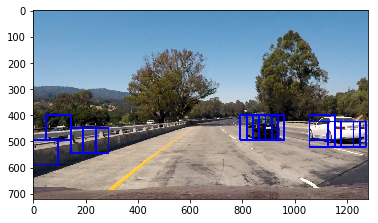

In [26]:
test_image = mpimg.imread('test_images/test1.jpg')

#plt.imshow(test_image)

rectangles = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

image_with_boxes = np.copy(test_image)
image_with_boxes = draw_boxes(image_with_boxes, rectangles)

plt.imshow(image_with_boxes)

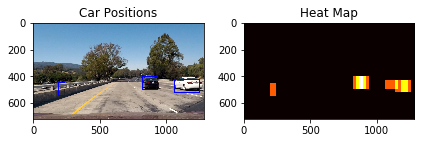

In [30]:
from scipy.ndimage.measurements import label

heat = np.zeros_like(test_image[:,:,0]).astype(np.float)


# Add heat to each box in box list
heat = add_heat(heat,rectangles)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


In [49]:
import pickle

notcars = glob.glob('../CarND-Vehicle-Detection-Data/non-vehicles/**/*.png')
cars = glob.glob('../CarND-Vehicle-Detection-Data/vehicles/**/*.png')


# No. of samples to consider for training
sample_size = 50

svc, X_scaler, accuracy_score = train(cars, notcars)

vehicle_detector = { "svc": svc, "X_scaler": X_scaler }

with open('data.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(vehicle_detector, f, pickle.HIGHEST_PROTOCOL)

no. of not car images is  8968
no. of car images is  8792
X_train shape (80, 6108)
X_test shape (20, 6108)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
0.02 Seconds to train SVC...
Test Accuracy of SVC =  0.95


spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105
no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105
no. of rectangles found is  23


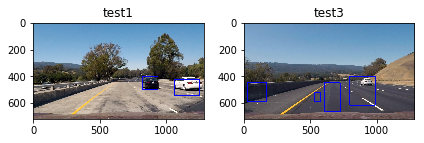

In [62]:
from scipy.ndimage.measurements import label

def pipeline(image):

    vehicle_detector = {}
    
    with open('data.pickle', 'rb') as f:
        vehicle_detector = pickle.load(f)
    
    svc = vehicle_detector["svc"]
    X_scaler = vehicle_detector["X_scaler"]
    
    rectangles = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,rectangles)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img
    
    
    

draw_img_1 = pipeline(mpimg.imread('test_images/test1.jpg'))
draw_img_2 = pipeline(mpimg.imread('test_images/test3.jpg'))
#plt.imshow(draw_img)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img_1)
plt.title('test1')
plt.subplot(122)
plt.imshow(draw_img_2)
plt.title('test3')
fig.tight_layout()


In [48]:

# Import everything needed to edit/save/watch video clips# Import 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Test the pipeline on the test video

test_video_output = 'vehicles_tracked_on_test_video.mp4'

clip = VideoFileClip('test_video.mp4')
#clip = VideoFileClip('test_video.mp4').subclip(1,2)
yellow_clip = clip.fl_image(pipeline)
%time yellow_clip.write_videofile(test_video_output, audio=False)

spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105
no. of rectangles found is  9
[MoviePy] >>>> Building video vehicles_tracked_on_test_video.mp4
[MoviePy] Writing video vehicles_tracked_on_test_video.mp4


  0%|          | 0/39 [00:00<?, ?it/s]

spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


  3%|▎         | 1/39 [00:00<00:21,  1.78it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


  5%|▌         | 2/39 [00:01<00:20,  1.79it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


  8%|▊         | 3/39 [00:01<00:19,  1.81it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 10%|█         | 4/39 [00:02<00:19,  1.78it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 13%|█▎        | 5/39 [00:02<00:19,  1.77it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 15%|█▌        | 6/39 [00:03<00:18,  1.78it/s]

no. of rectangles found is  16
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 18%|█▊        | 7/39 [00:03<00:18,  1.78it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 21%|██        | 8/39 [00:04<00:17,  1.77it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 23%|██▎       | 9/39 [00:05<00:16,  1.77it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 26%|██▌       | 10/39 [00:05<00:16,  1.76it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 28%|██▊       | 11/39 [00:06<00:15,  1.77it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 31%|███       | 12/39 [00:06<00:15,  1.78it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 33%|███▎      | 13/39 [00:07<00:14,  1.79it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 36%|███▌      | 14/39 [00:07<00:14,  1.77it/s]

no. of rectangles found is  17
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 38%|███▊      | 15/39 [00:08<00:13,  1.75it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 41%|████      | 16/39 [00:09<00:13,  1.75it/s]

no. of rectangles found is  9
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 44%|████▎     | 17/39 [00:09<00:12,  1.76it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 46%|████▌     | 18/39 [00:10<00:11,  1.77it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 49%|████▊     | 19/39 [00:10<00:11,  1.78it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 51%|█████▏    | 20/39 [00:11<00:10,  1.78it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 54%|█████▍    | 21/39 [00:11<00:10,  1.79it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 56%|█████▋    | 22/39 [00:12<00:09,  1.79it/s]

no. of rectangles found is  15
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 59%|█████▉    | 23/39 [00:12<00:08,  1.80it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 62%|██████▏   | 24/39 [00:13<00:08,  1.80it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 64%|██████▍   | 25/39 [00:13<00:07,  1.81it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 67%|██████▋   | 26/39 [00:14<00:07,  1.81it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 69%|██████▉   | 27/39 [00:14<00:06,  1.81it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 72%|███████▏  | 28/39 [00:15<00:06,  1.82it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 74%|███████▍  | 29/39 [00:15<00:05,  1.82it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 77%|███████▋  | 30/39 [00:16<00:04,  1.82it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 79%|███████▉  | 31/39 [00:17<00:04,  1.80it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 82%|████████▏ | 32/39 [00:17<00:03,  1.79it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 85%|████████▍ | 33/39 [00:18<00:03,  1.79it/s]

no. of rectangles found is  14
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 87%|████████▋ | 34/39 [00:18<00:02,  1.79it/s]

no. of rectangles found is  11
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 90%|████████▉ | 35/39 [00:19<00:02,  1.80it/s]

no. of rectangles found is  12
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 92%|█████████▏| 36/39 [00:20<00:01,  1.80it/s]

no. of rectangles found is  13
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 95%|█████████▍| 37/39 [00:20<00:01,  1.80it/s]

no. of rectangles found is  10
spatial_size  (16, 16)
hist  16
orient  9
ch1.shape[1]  853
pix_per_cell  8
(ch1.shape[1] // pix_per_cell)  106
cell_per_block  2
nxblocks  105


 97%|█████████▋| 38/39 [00:21<00:00,  1.80it/s]

no. of rectangles found is  12


[MoviePy] Done.
[MoviePy] >>>> Video ready: vehicles_tracked_on_test_video.mp4 

CPU times: user 20.9 s, sys: 643 ms, total: 21.5 s
Wall time: 21.8 s
